In [1]:
import pandas as pd
import numpy as np
import gwaslab as gl
import seaborn as sns
import matplotlib.pyplot as plt
# gwaslab annotation with ENSEMBL
from gwaslab.getsig import annogene


# locus

In [ ]:
# Merged 16 AHA GWAS; correct with sex,age,bmi,bsa,sbp,dbp,pc1-10
def get_mysumstats(gwaspath):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    return mysumstats

spatial_sumstats_WT= get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2/40kahat64_sexagebmibsa2bp_{}_merged.regenie.gz'.format('WT'))
spatial_sumstats_Ecc = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2/40kahat64_sexagebmibsa2bp_{}_merged.regenie.gz'.format('Ecc'))
spatial_sumstats_Ecc.data['BETA'] = -spatial_sumstats_Ecc.data['BETA']
spatial_sumstats_Err = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2/40kahat64_sexagebmibsa2bp_{}_merged.regenie.gz'.format('Err'))
wtmax_sumstats = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2_global/AHA_40k_t14_2bp_{}_Global_chrmerged_filtered.regenie.gz'.format('WT_Max'))

global_sumstats_WT= get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2_global/AHA_40k_t14_2bp_{}_Global_chrmerged_filtered.regenie.gz'.format('WT'))
global_sumstats_Ecc = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2_global/AHA_40k_t14_2bp_{}_Global_chrmerged_filtered.regenie.gz'.format('Ecc'))
global_sumstats_Err = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2_global/AHA_40k_t14_2bp_{}_Global_chrmerged_filtered.regenie.gz'.format('Err'))

global_sumstats_LVM = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2_global/AHA_40k_t14_2bp_{}_chrmerged_filtered.regenie.gz'.format('LVM'))
global_sumstats_LVEF = get_mysumstats('cardiac/48K/gwas_aha_t64/gwas_raw_p2_global/AHA_40k_t14_2bp_{}_chrmerged_filtered.regenie.gz'.format('LVEF'))

In [47]:
# Read the FUMA locus (at threshold 5e-8/16=3.125e-9) and check with any global sumstats
locus_WT = pd.read_csv('cardiac/48K/gwas_aha_t64/fuma/br_WT/GenomicRiskLoci.txt', sep='\t')
locus_Ecc = pd.read_csv('cardiac/48K/gwas_aha_t64/fuma/br_Ecc/GenomicRiskLoci.txt', sep='\t')
locus_Err = pd.read_csv('cardiac/48K/gwas_aha_t64/fuma/br_Err/GenomicRiskLoci.txt', sep='\t')
print('WT alone: {}'.format(locus_WT.shape[0]))
print('Ecc alone: {}'.format(locus_Ecc.shape[0]))
print('Err alone: {}'.format(locus_Err.shape[0]))

# Fuman locus performed from the minimum of all 48 traits to identify the largest locus window across all traits
locus_all = pd.read_csv('cardiac/48K/gwas_aha_t64/fuma/br_allll/GenomicRiskLoci.txt', sep='\t')

# check for each locus in "spatial_leads", if there is any SNPs that reach the threshold in "global_sumstats"
def check_fumalocus_in_sumstats(global_sumstats, spatial_leads, threshold=5e-8):
    In_GLOBAL = []
    for idx, row in spatial_leads.iterrows():
        set1 = global_sumstats.data[global_sumstats.data.CHR==row.chr]
        set1 = set1[(set1.POS>=row.start) & (set1.POS<=row.end)]
        try:
            set1n = sum(set1.MLOG10P>-np.log10(threshold))
        except:
            set1n = sum(set1.P<threshold)
        if set1n>0:
            In_GLOBAL.append(True)
        else:
            In_GLOBAL.append(False)
    return In_GLOBAL


# check for each locus in "spatial_leads", if there is any SNPs that reach the threshold in global sumstats including WT, Ecc, Err, LVM, LVEF
def check_global(spatial_leads, threshold=5e-8):
    In_GLOBAL = []
    for idx, row in spatial_leads.iterrows():
        isglobal = False
        for global_sumstats in [global_sumstats_WT, global_sumstats_Ecc, global_sumstats_Err, global_sumstats_LVM, global_sumstats_LVEF]:
            set1 = global_sumstats.data[global_sumstats.data.CHR==row.chr]
            set1 = set1[(set1.POS>=row.start) & (set1.POS<=row.end)]
            if 'MLOG10P' in set1.columns:
                set1n = sum(set1.MLOG10P>-np.log10(threshold))
            else:
                set1n = sum(set1.P<threshold)
            if set1n>0:
                isglobal = True
                break
        In_GLOBAL.append(isglobal)
    return In_GLOBAL

locus_all = locus_all.assign(
    WT = check_fumalocus_in_sumstats(spatial_sumstats_WT, locus_all, threshold=5e-8/16),
    WT_Global = check_fumalocus_in_sumstats(global_sumstats_WT, locus_all, threshold=5e-8),
    Ecc = check_fumalocus_in_sumstats(spatial_sumstats_Ecc, locus_all, threshold=5e-8/16),
    Ecc_Global = check_fumalocus_in_sumstats(global_sumstats_Ecc, locus_all, threshold=5e-8),
    Err = check_fumalocus_in_sumstats(spatial_sumstats_Err, locus_all, threshold=5e-8/16),
    Err_Global = check_fumalocus_in_sumstats(global_sumstats_Err, locus_all, threshold=5e-8),
    In_Global = check_global(locus_all, threshold=5e-8),
) 
print('WT: spatial locus {}, {} not in global WT'.format(sum(locus_all.WT), sum(locus_all.WT) - locus_all[locus_all.WT].WT_Global.sum()))
print('Ecc: spatial locus {}, {} not in global Ecc'.format(sum(locus_all.Ecc), sum(locus_all.Ecc) - locus_all[locus_all.Ecc].Ecc_Global.sum()))
print('Err: spatial locus {}, {} not in global Err'.format(sum(locus_all.Err), sum(locus_all.Err) - locus_all[locus_all.Err].Err_Global.sum()))

print('Total: {}, {} not in any global'.format(locus_all.shape[0], locus_all.shape[0] - locus_all.In_Global.sum()))

locus_all = locus_all.assign(Not_in_global = ~locus_all.In_Global)

WT alone: 21
Ecc alone: 16
Err alone: 18
WT: spatial locus 21, 9 not in global WT
Ecc: spatial locus 16, 5 not in global Ecc
Err: spatial locus 18, 11 not in global Err
Total: 42, 18 not in any global


In [ ]:
# Manhattan plot
spatial_color="#7df55f"
global_color="#fce5a4"
spatial_color = plt.cm.Accent(0)
global_color = plt.cm.Accent(2)
def plot_manhattan(spatial_sumstats, spatial_leads, savepath=None):
    # add LOCUS column: GenomicLocus is the LOCUS, rsID is the SNPID
    spatial_leads.rename(columns={'GenomicLocus':'LOCUS', 'rsID': 'SNPID'}, inplace=True)
    onelead_per_locus = spatial_leads.copy()
    if 'LOCUS' not in spatial_sumstats.data.columns:
        # join with spatial_leads
        spatial_sumstats.data = spatial_sumstats.data.join(spatial_leads.set_index('SNPID')[['LOCUS']], on='SNPID')
        # set non-NaN LOCUS to integer
        spatial_sumstats.data['LOCUS'] = spatial_sumstats.data['LOCUS'].fillna(-1).astype(int)
    for loc in [8,28,29,39]:
        x = spatial_sumstats.data[spatial_sumstats.data.LOCUS==loc].sort_values(by='MLOG10P', ascending=False)
        x = x['SNPID'].tolist()
        x = x[1:]
        onelead_per_locus = onelead_per_locus[~onelead_per_locus.SNPID.isin(x)]
    # plot
    fig, log = spatial_sumstats.plot_mqq(figargs={'figsize':(28,5)}, 
                                        mode="m", scaled=True, build="19", 
                                        skip=2, mlog10p='MLOG10P', ylim=[2,25], 
                                        fontsize=25, anno_fontsize = 25, verbose=True, 
                                        colors=sns.color_palette("gray", 4)[-2:], 
                                        sig_level=5e-8, additional_line=[5e-8/16], additional_line_color=["green"], 
                                        highlight=onelead_per_locus['SNPID'], 
                                        highlight_anno_args={
                                            # 'fontweight':'bold',
                                            'color': global_color,
                                        },
                                        highlight_set2=onelead_per_locus[~onelead_per_locus.In_GLOBAL]['SNPID'], 
                                        highlight_set2_anno_args={
                                            'fontweight':'bold',
                                            'color':spatial_color,
                                        },
                                        anno='LOCUS', anno_set=onelead_per_locus['SNPID'], anno_style="expand", 
                                        # anno_style="tight", repel_force=0.02,
                                        )
    # fig axes vertical grid lines remove
    fig.axes[0].xaxis.grid(False)
    # set y axis ticks to 2,5,10,20
    fig.axes[0].set_yticks([2,5,10,15,20])
    # remove xlabel
    fig.axes[0].set_xlabel('')
    # check if fig is overflown
    fig.tight_layout()
    if savepath is not None:
        fig.savefig(savepath, dpi=600)

plot_manhattan(spatial_sumstats_WT, locus_multi_lead[locus_multi_lead.WT].rename(columns={'WT_Global':'In_GLOBAL'}), savepath='/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/arrayGWAS_WT.manhattan.png')
plot_manhattan(spatial_sumstats_Ecc, locus_multi_lead[locus_multi_lead.Ecc].rename(columns={'Ecc_Global':'In_GLOBAL'}), savepath='/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/arrayGWAS_Ecc.manhattan.png')
plot_manhattan(spatial_sumstats_Err, locus_multi_lead[locus_multi_lead.Err].rename(columns={'Err_Global':'In_GLOBAL'}), savepath='/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/arrayGWAS_Err.manhattan.png')

In [ ]:
# Load HCM, DCM
hcm_gwas_path = 'cardiac/summary_stats/HCM_meta_analysis_2023/gwama_sumstat/hcm.gwama.txt.gz'
dcm_gwas_path = 'cardiac/summary_stats/HERMES_HNDC_meta_analysis_2023/FORMAT-METAL_Pheno5_EUR.tsv'
hcm_mysumstats = gl.Sumstats(hcm_gwas_path, 
                         snpid='snptestid',
             rsid='rsid',
             chrom='chr',
             pos='pos',
             ea='effect_allele',
             nea='noneffect_allele',
             eaf='eaf',
             n='n_samples',
             beta='beta',
             se='se',
             p='pvalue',
             verbose=False)

dcm_mysumstats = gl.Sumstats(dcm_gwas_path, 
                            #  key    rsID    chr     pos_b37 A1      A2      A1_beta A1_freq se      pval    logP     N_case  N_total isq_het p_het
                         snpid='#key',
             rsid='rsID',
             chrom='chr',
             pos='pos_b37',
             ea='A1',
             nea='A2',
             eaf='A1_freq',
             n='N_total',
             beta='A1_beta',
             se='se',
             p='pval',
             verbose=False)

In [14]:
# check if leads are in HCM, DCM
In_HCM = []
In_DCM = []
for idx, row in locus_all.iterrows():
    set1 = hcm_mysumstats.data[hcm_mysumstats.data.CHR==str(row.chr)]
    set1 = set1[(set1.POS>=row.start) & (set1.POS<=row.end)]
    set1n = sum(set1.P<5e-8)
    set2 = dcm_mysumstats.data[dcm_mysumstats.data.CHR==str(row.chr)]
    set2 = set2[(set2.POS>=row.start) & (set2.POS<=row.end)]
    set2n = sum(set2.P<5e-8)
    if set1n>0:
        In_HCM.append(True)
    else:
        In_HCM.append(False)
    if set2n>0:
        In_DCM.append(True)
    else:
        In_DCM.append(False)
locus_all = locus_all.assign(HCM=In_HCM, DCM=In_DCM)

In [16]:
# calculate q-value
from qvalue_python3 import qvalue_estimate
hcm_mysumstats.data = hcm_mysumstats.data.assign(QVALUE=qvalue_estimate(hcm_mysumstats.data.P))
dcm_mysumstats.data = dcm_mysumstats.data.assign(QVALUE=qvalue_estimate(dcm_mysumstats.data.P))

In [17]:
# check if leads are in HCM, DCM FDR by q-value
In_HCM = []
In_DCM = []
for idx, row in locus_all.iterrows():
    set1 = hcm_mysumstats.data[hcm_mysumstats.data.CHR==str(row.chr)]
    set1 = set1[(set1.POS>=row.start) & (set1.POS<=row.end)]
    set1n = sum(set1.QVALUE<0.05)
    set2 = dcm_mysumstats.data[dcm_mysumstats.data.CHR==str(row.chr)]
    set2 = set2[(set2.POS>=row.start) & (set2.POS<=row.end)]
    set2n = sum(set2.QVALUE<0.05)
    if set1n>0:
        In_HCM.append(True)
    else:
        In_HCM.append(False)
    if set2n>0:
        In_DCM.append(True)
    else:
        In_DCM.append(False)
locus_all = locus_all.assign(HCM_FDR=In_HCM, DCM_FDR=In_DCM)

In [18]:
print('All in HCM: {} ({} by FDR5%), not in global in HCM: {} ({} by FDR5%)'.format(locus_all.HCM.sum(), locus_all.HCM_FDR.sum(), locus_all[locus_all.Not_in_global].HCM.sum(), locus_all[locus_all.Not_in_global].HCM_FDR.sum()))
print('All in DCM: {} ({} by FDR5%), not in global in DCM: {} ({} by FDR5%)'.format(locus_all.DCM.sum(), locus_all.DCM_FDR.sum(), locus_all[locus_all.Not_in_global].DCM.sum(), locus_all[locus_all.Not_in_global].DCM_FDR.sum()))
print('Total in HCM or DCM 5% FDR: {}'.format(locus_all[locus_all.HCM_FDR | locus_all.DCM_FDR].shape[0]))
print('Total Not_in_global in HCM or DCM 5% FDR: {}'.format(locus_all[locus_all.Not_in_global & (locus_all.HCM_FDR | locus_all.DCM_FDR)].shape[0]))

print('Not in global in HCM: {}, {}'.format(locus_all[locus_all.Not_in_global & locus_all.HCM].GenomicLocus.tolist(), locus_all[locus_all.Not_in_global & locus_all.HCM_FDR].GenomicLocus.tolist()))
print('Not in global in DCM: {}, {}'.format(locus_all[locus_all.Not_in_global & locus_all.DCM].GenomicLocus.tolist(), locus_all[locus_all.Not_in_global & locus_all.DCM_FDR].GenomicLocus.tolist()))

All in HCM: 15 (24 by FDR5%), not in global in HCM: 5 (9 by FDR5%)
All in DCM: 8 (16 by FDR5%), not in global in DCM: 1 (4 by FDR5%)
Total in HCM or DCM 5% FDR: 27
Total Not_in_global in HCM or DCM 5% FDR: 11
Not in global in HCM: [6, 17, 26, 29, 31], [1, 6, 11, 17, 26, 29, 31, 33, 36]
Not in global in DCM: [13], [1, 6, 13, 15]


In [20]:
# locus with HCM/DCM annotations; the qvalue part takes a long time
locus_all = locus_all.astype({'WT':int, 'Ecc':int, 'Err':int, 'WT_Global':int, 'Ecc_Global':int, 'Err_Global':int, 'Not_in_global':int, 'HCM':int, 'DCM':int, 'HCM_FDR':int, 'DCM_FDR':int})
locus_all.to_csv('spatial_loci_threshold_3e-9.csv', index=False)

In [7]:
# read
locus_all = pd.read_csv('../quick_access/GWAS/spatial_loci_threshold_3e-9.csv')
# # .drop(columns=['symbols_x', 'positional_protein_coding_x', 'eQTL_LV_protein_coding_x',
#        'ciMap_LV_protein_coding_x', 'positional_miRNA_x', 'ciMap_LV_miRNA_x',
#        'Familial_HCM', 'Familial_DCM', 'symbols_y',
#        'positional_protein_coding_y', 'eQTL_LV_protein_coding_y',
#        'ciMap_LV_protein_coding_y', 'positional_miRNA_y', 'ciMap_LV_miRNA_y',
#        'positional_protein_coding', 'eQTL_LV_protein_coding',
#        'ciMap_LV_protein_coding', 'positional_miRNA', 'ciMap_LV_miRNA'])
print(locus_all.shape, locus_all.columns)

(42, 36) Index(['GenomicLocus', 'uniqID', 'rsID', 'chr', 'pos', 'p', 'start', 'end',
       'nSNPs', 'nGWASSNPs', 'nIndSigSNPs', 'IndSigSNPs', 'nLeadSNPs',
       'LeadSNPs', 'WT', 'Ecc', 'Err', 'In_Global', 'WT_Global', 'Ecc_Global',
       'Err_Global', 'Not_in_global', 'HCM', 'DCM', 'HCM_FDR', 'DCM_FDR',
       'FIG2GENE', 'symbols', 'positional_protein_coding',
       'eQTL_LV_protein_coding', 'ciMap_LV_protein_coding', 'positional_miRNA',
       'ciMap_LV_miRNA', 'other', 'Familial_HCM', 'Familial_DCM'],
      dtype='object')


# Gene prioritization

In [28]:
# FUMA LOCUS annotation, with positional mapping, eQTL mapping, ci mapping
# locus annotation; for eQTL and ciMap I just need to know yes or no; and get a list of genes for that locus to prioritize
# ensg	symbol	chr	start	end	strand	type	entrezID	HUGO	pLI	ncRVIS	posMapSNPs	posMapMaxCADD	eqtlMapSNPs	eqtlMapminP	eqtlMapminQ	eqtlMapts	eqtlDirection	ciMap	ciMapts	minGwasP	IndSigSNPs	GenomicLocus
genes = pd.read_csv('cardiac/48K/gwas_aha_t64/fuma/br_allll/genes.txt', sep='\t')
genes = genes[genes.minGwasP<5e-8/16]

# type of genes
print(genes.type.value_counts())
# a protein coding subset

# number of genes that have posMapSNPs, eqtlMapSNPs, ciMap
print('total genes:', genes.shape[0])
print('Number of genes with posMapSNPs:', sum(genes.posMapSNPs>0))
print('Number of genes with eqtlMapSNPs:', sum(genes.eqtlMapSNPs>0))
print('Number of genes with ciMap:', sum(genes.ciMap=='Yes'))

# process eqtl
# tissues: ['Artery_Aorta' 'Artery_Tibial' 'Heart_Atrial_Appendage' 'Heart_Left_Ventricle' 'Artery_Coronary'] 
genes = genes.assign(Heart_Left_Ventricle_eqtl = genes['eqtlMapts'].map(lambda x : True if isinstance(x, str) and 'Heart_Left_Ventricle' in x else False))
genes = genes.assign(Heart_Left_Ventricle_ciMap = genes['ciMapts'].map(lambda x : True if isinstance(x, str) and 'Left_Ventricle' in x else False))

print('Number of genes with Heart_Left_Ventricle eqtl:', sum(genes.Heart_Left_Ventricle_eqtl))
print('Number of genes with Heart_Left_Ventricle ciMap:', sum(genes.Heart_Left_Ventricle_ciMap))

print('Number of genes positional or eqtl or ciMap in Heart_Left_Ventricle:', genes[(genes.posMapSNPs>0) | genes.Heart_Left_Ventricle_eqtl | genes.Heart_Left_Ventricle_ciMap].shape[0])

genes_LV = genes[(genes.posMapSNPs>0) | genes.Heart_Left_Ventricle_eqtl | genes.Heart_Left_Ventricle_ciMap ]

# # other eqtl
# genes = genes.assign(Artery_Tibial_eqtl = genes['eqtlMapts'].map(lambda x : True if isinstance(x, str) and 'Artery_Tibial' in x else False))
# genes = genes.assign(Artery_Aorta_eqtl = genes['eqtlMapts'].map(lambda x : True if isinstance(x, str) and 'Artery_Aorta' in x else False))
# genes = genes.assign(Heart_Atrial_Appendage_eqtl = genes['eqtlMapts'].map(lambda x : True if isinstance(x, str) and 'Heart_Atrial_Appendage' in x else False))
# genes = genes.assign(Artery_Coronary_eqtl = genes['eqtlMapts'].map(lambda x : True if isinstance(x, str) and 'Artery_Coronary' in x else False))


type
protein_coding          204
pseudogene               95
antisense                60
lincRNA                  44
miRNA                    18
snRNA                    17
misc_RNA                 15
snoRNA                   11
sense_intronic            9
processed_transcript      8
rRNA                      1
Name: count, dtype: int64
total genes: 482
Number of genes with posMapSNPs: 212
Number of genes with eqtlMapSNPs: 142
Number of genes with ciMap: 294
Number of genes with Heart_Left_Ventricle eqtl: 68
Number of genes with Heart_Left_Ventricle ciMap: 290
Number of genes positional or eqtl or ciMap in Heart_Left_Ventricle: 455


In [61]:
# THE 455 LV gene products
genes_LV = genes[(genes.posMapSNPs>0) | genes.Heart_Left_Ventricle_eqtl | genes.Heart_Left_Ventricle_ciMap ].copy()
# genes_LV = genes_LV[genes_LV.posMapMaxCADD>12.37]
# genes_LV = genes_LV[['symbol', 'type', 'GenomicLocus', 'posMapSNPs', 'Heart_Left_Ventricle_eqtl', 'Heart_Left_Ventricle_ciMap', 'eqtlMapSNPs', 'eqtlDirection']]
# genes_LV[genes_LV.Heart_Left_Ventricle_eqtl][['symbol', 'type', 'GenomicLocus', 'posMapSNPs', 'eqtlMapSNPs', 'eqtlDirection']]
# ADD In_Global column from locus_all use GenomicLocus
genes_LV = genes_LV.merge(locus_all[['GenomicLocus', 'Not_in_global']], on='GenomicLocus', how='left')

# replace ciMap Yes with 1 and No with 0
genes_LV['ciMap'].replace({'Yes':1, 'No':0}, inplace=True)
print(genes_LV.columns)
# set type as Categorical 
genes_LV['type'] = pd.Categorical(genes_LV['type'], categories=['sense_intronic', 'antisense', 'pseudogene', 'snRNA', 'snoRNA',
       'lincRNA', 'misc_RNA', 'processed_transcript', 'rRNA', 'miRNA','protein_coding'], ordered=True)
genes_LV.sort_values(by=['type', 'posMapMaxCADD', 'posMapSNPs', 'eqtlMapSNPs', 'ciMap'], ascending=False)[['type','GenomicLocus', 'Not_in_global', 'symbol', 'posMapMaxCADD','posMapSNPs', 'eqtlMapSNPs', 'ciMap', 'minGwasP', 'IndSigSNPs', 'pLI']].to_csv('spatial_loci_threshold_3e-9_genes_LV.csv', index=False)

Index(['ensg', 'symbol', 'chr', 'start', 'end', 'strand', 'type', 'entrezID',
       'HUGO', 'pLI', 'ncRVIS', 'posMapSNPs', 'posMapMaxCADD', 'eqtlMapSNPs',
       'eqtlMapminP', 'eqtlMapminQ', 'eqtlMapts', 'eqtlDirection', 'ciMap',
       'ciMapts', 'minGwasP', 'IndSigSNPs', 'GenomicLocus',
       'Heart_Left_Ventricle_eqtl', 'Heart_Left_Ventricle_ciMap',
       'Not_in_global'],
      dtype='object')


In [65]:
# protein coding genes
# THE 455 LV gene products
genes_LV = genes[(genes_LV.posMapMaxCADD>12.37) | genes.Heart_Left_Ventricle_eqtl | genes.Heart_Left_Ventricle_ciMap ].copy()
genes_LV = genes_LV[genes_LV.type=='protein_coding']
print(genes_LV.shape)
# genes_LV = genes_LV[genes_LV.posMapMaxCADD>12.37]
# genes_LV = genes_LV[['symbol', 'type', 'GenomicLocus', 'posMapSNPs', 'Heart_Left_Ventricle_eqtl', 'Heart_Left_Ventricle_ciMap', 'eqtlMapSNPs', 'eqtlDirection']]
# genes_LV[genes_LV.Heart_Left_Ventricle_eqtl][['symbol', 'type', 'GenomicLocus', 'posMapSNPs', 'eqtlMapSNPs', 'eqtlDirection']]
# ADD In_Global column from locus_all use GenomicLocus
genes_LV = genes_LV.merge(locus_all[['GenomicLocus', 'Not_in_global']], on='GenomicLocus', how='left')

# replace ciMap Yes with 1 and No with 0
genes_LV['ciMap'].replace({'Yes':1, 'No':0}, inplace=True)
print(genes_LV.columns)
# set type as Categorical 
genes_LV.sort_values(by=['Not_in_global', 'posMapMaxCADD', 'eqtlMapSNPs', 'ciMap'], ascending=False)[['Not_in_global','GenomicLocus', 'symbol', 'posMapMaxCADD','posMapSNPs', 'eqtlMapSNPs', 'ciMap', 'minGwasP', 'IndSigSNPs', 'pLI']].to_csv('spatial_loci_threshold_3e-9_protein_coding_LV.csv', index=False)

(113, 25)
Index(['ensg', 'symbol', 'chr', 'start', 'end', 'strand', 'type', 'entrezID',
       'HUGO', 'pLI', 'ncRVIS', 'posMapSNPs', 'posMapMaxCADD', 'eqtlMapSNPs',
       'eqtlMapminP', 'eqtlMapminQ', 'eqtlMapts', 'eqtlDirection', 'ciMap',
       'ciMapts', 'minGwasP', 'IndSigSNPs', 'GenomicLocus',
       'Heart_Left_Ventricle_eqtl', 'Heart_Left_Ventricle_ciMap',
       'Not_in_global'],
      dtype='object')


/var/folders/6y/1p43n3zs7zn39bj64mc3fmmc0000gn/T/ipykernel_61847/2483902564.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  genes_LV = genes[(genes_LV.posMapMaxCADD>12.37) | genes.Heart_Left_Ventricle_eqtl | genes.Heart_Left_Ventricle_ciMap ].copy()


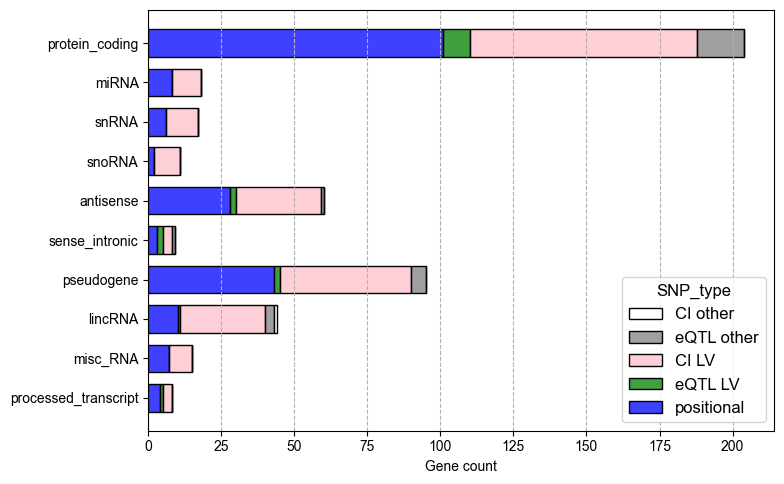

In [4]:
# annotate each gene with whether has posMapSNPs, eqtlMapSNPs
genes_type_plot = genes.assign(
    SNP_type = genes.ciMap.apply(lambda x: 'CI other' if x=='Yes' else 'NA'),
)
genes_type_plot.loc[genes_type_plot.eqtlMapSNPs>0, 'SNP_type'] = 'eQTL other'
genes_type_plot.loc[genes_type_plot.Heart_Left_Ventricle_ciMap, 'SNP_type'] = 'CI LV'
genes_type_plot.loc[genes_type_plot.Heart_Left_Ventricle_eqtl, 'SNP_type'] = 'eQTL LV'
genes_type_plot.loc[genes_type_plot.posMapSNPs>0, 'SNP_type'] = 'positional'
genes_type_plot['type'] = pd.Categorical(genes_type_plot['type'], categories=['protein_coding', 'miRNA', 'snRNA', 'snoRNA', 'antisense', 'sense_intronic', 'pseudogene', 'lincRNA', 'misc_RNA', 'processed_transcript'])


# plot the above type on y axis
fig, ax = plt.subplots(1,1,figsize=(8,5))
# font Arial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 12})

sns.histplot(data=genes_type_plot, y='type', hue='SNP_type', multiple='stack', ax=ax, 
             hue_order=['positional', 'eQTL LV',  'CI LV', 'eQTL other','CI other'][::-1],
             palette=['blue', 'green', 'pink', 'gray', 'white'][::-1],
             shrink=0.7, legend=True)
# x title is Gene count
plt.xlabel('Gene count')
plt.ylabel('')
# set legend title
# plt.legend(title='SNP type', loc='upper right')
# grid on x axis dashed
ax.xaxis.grid(True, linestyle='--')
plt.tight_layout()
# save
fig.savefig('/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/spatial_genetypes_threshold_3e-9.csv.pdf')

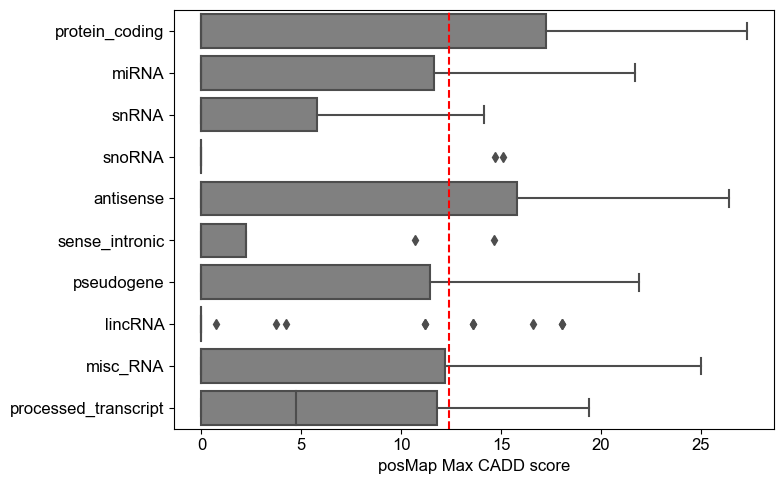

In [5]:
# plot distribution of posMapMaxCADD by type of genes
genes['type'] = pd.Categorical(genes['type'], categories=['protein_coding', 'miRNA', 'snRNA', 'snoRNA', 'antisense', 'sense_intronic', 'pseudogene', 'lincRNA', 'misc_RNA', 'processed_transcript'])

fig, ax = plt.subplots(1,1,figsize=(8,5))
# box plot type on y axis, posMapMaxCADD on x axis, same color
sns.boxplot(data=genes, y='type', x='posMapMaxCADD', ax=ax, color='gray')
plt.xlabel('posMap Max CADD score')
# threshold is 12.37
plt.axvline(x=12.37, color='red', linestyle='--')
plt.ylabel('')
plt.tight_layout()
fig.savefig('/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/spatial_genetypes_threshold_3e-9.posMapMaxCADD.pdf')


In [ ]:
# annotate locus with protein coding or miRNA genes that have positional, or heart left ventricle eqtl, or heart left ventricle ci
genes_to_annotate = genes[(genes.posMapSNPs>0) | (genes.Heart_Left_Ventricle_eqtl) | (genes.Heart_Left_Ventricle_ciMap)]
genes_to_annotate = genes_to_annotate[(genes_to_annotate.type.isin(['protein_coding', 'miRNA'])) | (genes_to_annotate.posMapMaxCADD>12.37)]
# group symbol by locus
locus_genes = genes_to_annotate.groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'symbols'})
toadd = genes_to_annotate[(genes_to_annotate.type=='protein_coding') & (genes_to_annotate.posMapSNPs>0)].groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'positional_protein_coding'})
locus_genes = locus_genes.merge(toadd, on='GenomicLocus', how='left')
toadd = genes_to_annotate[(genes_to_annotate.type=='protein_coding') & (genes_to_annotate.Heart_Left_Ventricle_eqtl)].groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'eQTL_LV_protein_coding'})
locus_genes = locus_genes.merge(toadd, on='GenomicLocus', how='left')
toadd = genes_to_annotate[(genes_to_annotate.type=='protein_coding') & (genes_to_annotate.Heart_Left_Ventricle_ciMap)].groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'ciMap_LV_protein_coding'})
locus_genes = locus_genes.merge(toadd, on='GenomicLocus', how='left')
toadd = genes_to_annotate[(genes_to_annotate.type=='miRNA') & (genes_to_annotate.posMapSNPs>0)].groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'positional_miRNA'})
locus_genes = locus_genes.merge(toadd, on='GenomicLocus', how='left')
toadd = genes_to_annotate[(genes_to_annotate.type=='miRNA') & (genes_to_annotate.Heart_Left_Ventricle_ciMap)].groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'ciMap_LV_miRNA'})
locus_genes = locus_genes.merge(toadd, on='GenomicLocus', how='left')
toadd = genes_to_annotate[(~genes_to_annotate.type.isin(['protein_coding', 'miRNA'])) & (genes_to_annotate.posMapMaxCADD>12.37)].groupby('GenomicLocus')['symbol'].apply(lambda x: ','.join(x)).reset_index().rename(columns={'symbol':'other'})
locus_genes = locus_genes.merge(toadd, on='GenomicLocus', how='left')
locus_genes

In [14]:
# add to locus_all
locus_all = locus_all.merge(locus_genes, on='GenomicLocus', how='left')
locus_all.columns

Index(['GenomicLocus', 'uniqID', 'rsID', 'chr', 'pos', 'p', 'start', 'end',
       'nSNPs', 'nGWASSNPs', 'nIndSigSNPs', 'IndSigSNPs', 'nLeadSNPs',
       'LeadSNPs', 'WT', 'Ecc', 'Err', 'In_Global', 'WT_Global', 'Ecc_Global',
       'Err_Global', 'Not_in_global', 'HCM', 'DCM', 'HCM_FDR', 'DCM_FDR',
       'FIG2GENE', 'symbols', 'positional_protein_coding',
       'eQTL_LV_protein_coding', 'ciMap_LV_protein_coding', 'positional_miRNA',
       'ciMap_LV_miRNA', 'other'],
      dtype='object')

# Check with CardiacG2P 

In [10]:
locus_all = pd.read_csv('spatial_loci_threshold_3e-9.csv')

In [35]:
# check Cardiac G2P by the Genes
# Read Cardiac G2P
cardiac_g2p = pd.read_csv('/Users/clu/git/3D_cardiac_GWAS/the_paper/data/Cardiac_G2P.csv')
cardiac_genes = cardiac_g2p.groupby('Disease grouping').apply(lambda x: ','.join(x.Gene))
cardiac_genes = pd.DataFrame(cardiac_genes).rename(columns={0:'genes'})
# check if the genes are in the cardiac G2P
cardiac_genes = cardiac_genes.assign(Seen = cardiac_genes.genes.apply(lambda x: ','.join([y for y in x.split(',') if y in genes.symbol.values])))

# display
display(cardiac_genes)

Familial_HCM = set(cardiac_genes.loc['Familial hypertrophic cardiomyopathy', 'genes'].split(',')).union(cardiac_genes.loc['Rare syndromic disorder with hypertrophic cardiomyopathy - isolated LVH', 'genes'].split(',')).union(cardiac_genes.loc['Syndrome with hypertrophic cardiomyopathy - no isolated LVH', 'genes'].split(','))
Familial_DCM = set(cardiac_genes.loc['Familial dilated cardiomyopathy', 'genes'].split(','))


locus_all = locus_all.assign(Familial_HCM = locus_all.symbols.apply(lambda x: ','.join([y for y in x.split(',') if y in Familial_HCM])), 
                                     Familial_DCM = locus_all.symbols.apply(lambda x: ','.join([y for y in x.split(',') if y in Familial_DCM])))

,genes,Seen
Disease grouping,,
Atypical CPVT phenotype,"CALM1,CALM2,CALM3,TECRL,TRDN",
Brugada syndrome,SCN5A,
Classic CPVT phenotype,"RYR2,CASQ2,CASQ2","CASQ2,CASQ2"
Classic SQTS,"KCNH2,KCNQ1,SLC4A3,KCNJ2",
Familial Long QT Syndrome,"KCNQ1,KCNH2,SCN5A",
Familial dilated cardiomyopathy,"BAG3,DES,DSP,FLNC,LMNA,MYH7,PLN,RBM20,SCN5A,TN...","BAG3,MYH7,PLN,RBM20,TTN"
Familial hypertrophic cardiomyopathy,"ACTC1,MYBPC3,MYH7,MYL2,MYL3,PLN,TNNI3,TNNT2,TPM1","MYBPC3,MYH7,PLN"
Familial isolated arrhythmogenic cardiomyopathy,"DSC2,DSG2,DSP,PKP2,TMEM43",
Long QT syndrome with an atypical presentation,"CALM1,CALM2,CALM3,TRDN",


In [36]:
cardiac_genes.to_csv('cardiac_genes.csv')

In [16]:
# save locus_all again at the same place
locus_all.to_csv('spatial_loci_threshold_3e-9.csv', index=False)

# Make Figure heatmap plot

(-0.5, 41.5)
(-0.5, 41.5)


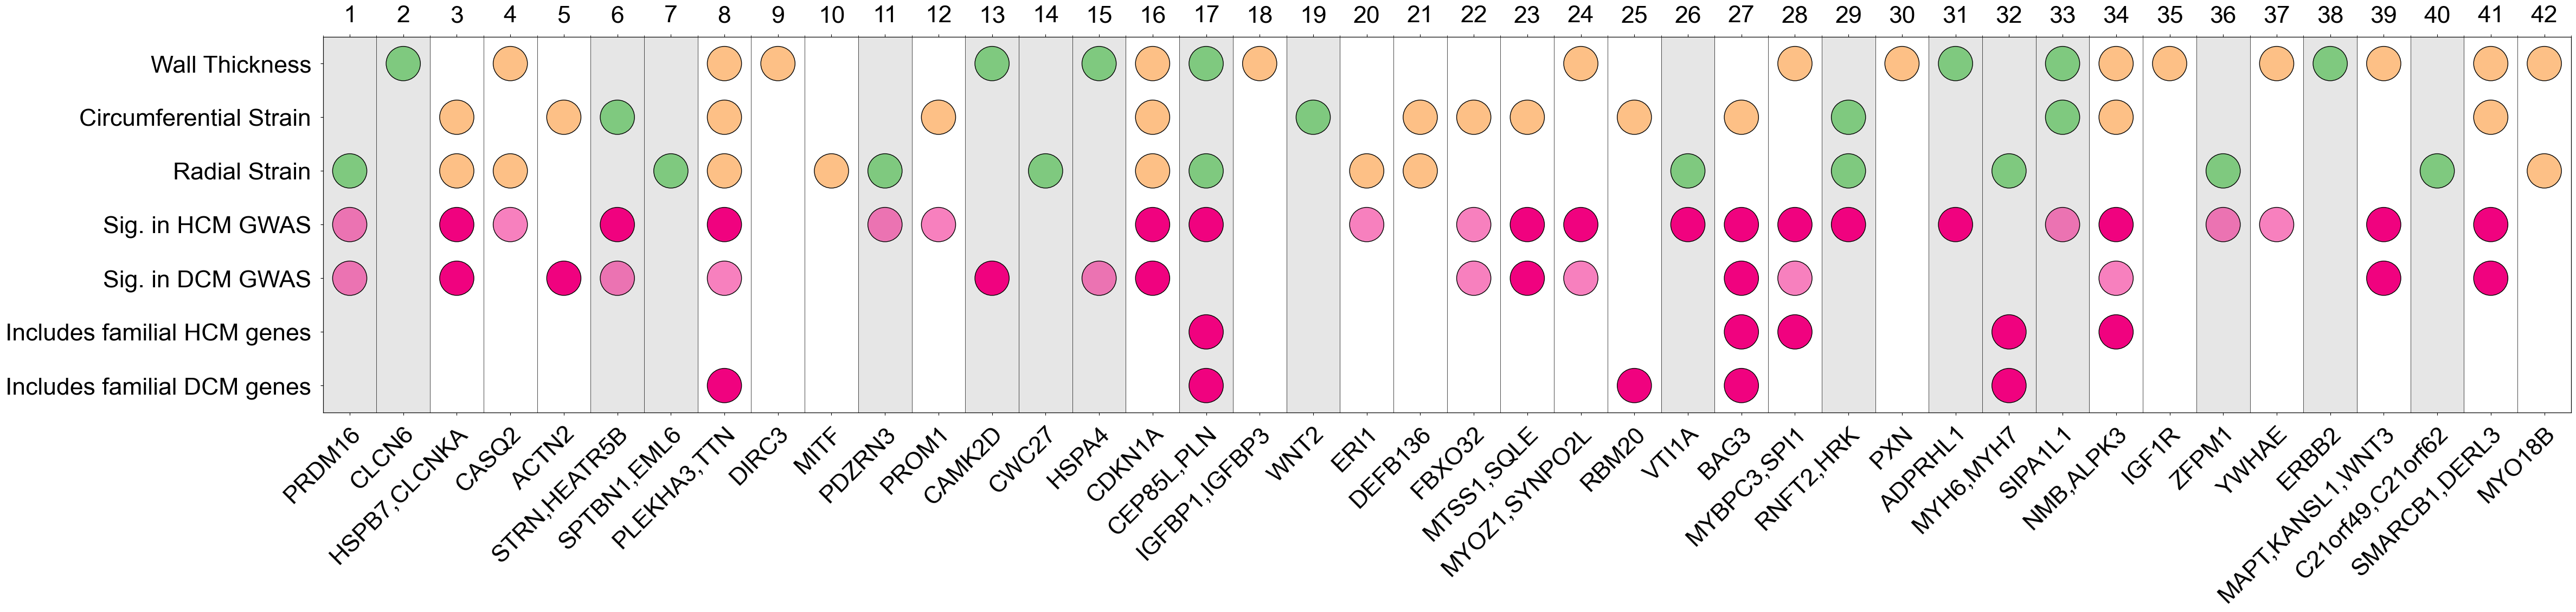

In [12]:
# spatial_locus = pd.read_csv('../quick_access/GWAS/spatial_loci_threshold_3e-9.csv')
spatial_locus = pd.read_csv('../quick_access/GWAS/spatial_loci_threshold_3e-9_wFIG2GENE.csv')

# change the background shade to spatial only; and include the familial HCM and DCM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import PatchCollection
plt.rcParams['font.family'] = ['Arial']
# font size
plt.rcParams.update({'font.size': 32})

# x axis is the locus
xlabels = spatial_locus['FIG2GENE'].tolist()
M = len(xlabels)

# y axis are the tags
ylabels = ['WT', 'Ecc', 'Err', 'HCM', 'DCM', 'Familial_HCM', 'Familial_DCM'] 
# 'posGene', 'LV_eqtl', 'Cornoary_eqtl', 'Aorta_eqtl', 'Appendage_eqtl', 'LV_ciMap']
N = len(ylabels)
ylabels_text = ['Wall Thickness', 'Circumferential Strain', 'Radial Strain', 'Sig. in HCM GWAS',  'Sig. in DCM GWAS', 'Includes familial HCM genes', 'Includes familial DCM genes']
# 'Positional gene', 'Left Ventricle eQTL', 'Coronary Artery eQTL', 'Aorta eQTL', 'Appendage eQTL', 'Left Ventricle ciMap']

x, y = np.meshgrid(np.arange(M), np.arange(N))

# colors
# cmap: Accent, numbers by colors_num

## Spatial loci
yaxis_p1 = spatial_locus[['FIG2GENE','WT', 'Ecc', 'Err']].copy()
yaxis_p1 = yaxis_p1.assign(WT_Global = np.all(spatial_locus[['WT_Global', 'WT']], axis=1), Ecc_Global = np.all(spatial_locus[['Ecc_Global', 'Ecc']], axis=1), Err_Global = np.all(spatial_locus[['Err_Global', 'Err']], axis=1))
yaxis_p1 = yaxis_p1.astype({'WT':float, 'Ecc':float, 'Err':float, 'WT_Global':float, 'Ecc_Global':float, 'Err_Global':float})
# Radius: plot circle 
radius_p1 = yaxis_p1[['FIG2GENE','WT', 'Ecc', 'Err']].copy().set_index('FIG2GENE')
radius_p1[radius_p1==1] = 0.8
# Color:
color_p1 = yaxis_p1.assign(WT = yaxis_p1.WT + yaxis_p1.WT_Global, Ecc = yaxis_p1.Ecc + yaxis_p1.Ecc_Global, Err = yaxis_p1.Err + yaxis_p1.Err_Global)
color_p1 = color_p1[['FIG2GENE','WT', 'Ecc', 'Err']].copy().set_index('FIG2GENE')
# 1. color => Whether locus is significant in global
color_p1[color_p1==0] = pd.NA
color_p1[color_p1==1] = 0 # green
color_p1[color_p1==2] = 2 # orange

## Whether locus seen in HCM, DCM
# y axis HCM, DCM
yaxis_p2 = spatial_locus[['FIG2GENE','HCM', 'DCM', 'HCM_FDR', 'DCM_FDR']].copy()
yaxis_p2 = yaxis_p2.assign(Familial_HCM = spatial_locus.Familial_HCM.notna(), Familial_DCM = spatial_locus.Familial_DCM.notna())
yaxis_p2 = yaxis_p2.astype({'HCM':float, 'DCM':float, 'HCM_FDR':float, 'DCM_FDR':float, 'Familial_HCM':float, 'Familial_DCM':float})

yaxis_p2 = yaxis_p2.assign(HCM = yaxis_p2.HCM + yaxis_p2.HCM_FDR, DCM = yaxis_p2.DCM + yaxis_p2.DCM_FDR)
                            
# Radius: plot circle 
# radius_p2 = yaxis_p2[['FIG2GENE','HCM', 'Familial_HCM', 'DCM', 'Familial_DCM']].copy().set_index('FIG2GENE')
radius_p2 = yaxis_p2[['FIG2GENE','HCM', 'DCM', 'Familial_HCM', 'Familial_DCM']].copy().set_index('FIG2GENE')
radius_p2[radius_p2>0] = 0.8
# Color:
# color_p2 = yaxis_p2[['FIG2GENE','HCM', 'Familial_HCM', 'DCM', 'Familial_DCM']].copy().set_index('FIG2GENE')
color_p2 = yaxis_p2[['FIG2GENE','HCM', 'DCM', 'Familial_HCM', 'Familial_DCM']].copy().set_index('FIG2GENE')
# 2. color => has radius for all seen in HCM, DCM
color_p2[color_p2==1] = 4.5 # purple alpha 0.6
color_p2[color_p2==2] = 5 # also purple
# set 2 columns where value is 5 to 4
color_p2[['Familial_HCM', 'Familial_DCM']] = color_p2[['Familial_HCM', 'Familial_DCM']].replace(4.5, 5)

## Make Radius
radius = pd.concat([radius_p1, radius_p2], axis=1)
# make sure of the order
radius = radius.reindex(xlabels)
radius = radius.reindex(ylabels, axis=1)
radius = radius.T
R = radius.values/2.5

## Make Color
color = pd.concat([color_p1, color_p2], axis=1)
color = color.reindex(xlabels)
color = color.reindex(ylabels, axis=1)
color = color.T
color_num = color.values

## Make alpha
alpha_num = np.ones(color_num.shape)
alpha_num[color_num==4.5] = 0.5
alpha_num[color_num==4] = 0.8

# set figure size
fig, ax = plt.subplots()
fig.set_size_inches(53.5, 9)

# plot background
# odds is 1 even is 0
locus = pd.DataFrame({'locus':[0.5 if spatial_locus.loc[i, 'Not_in_global']==0 else 0 for i in spatial_locus.index]}, index=spatial_locus.index)
locus = np.repeat(locus, N, axis=1).T
ax.imshow(locus, cmap=plt.cm.gray, alpha=0.1)
# vertical lines for locus
# index in the list of first occurrence of different number
locus_idx = np.array(spatial_locus.index)
ax.vlines(locus_idx-0.5, -0.5, N-0.5, color='black', linewidth=0.5)

# plot circles
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=color_num.flatten(), cmap="Accent", alpha=alpha_num.flatten())
# set col limits
col.set_clim(0, 7)
ax.add_collection(col)

# plot EDGE
circles2 = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col2 = PatchCollection(circles2, facecolor='none', edgecolor='black', linewidth=1)
ax.add_collection(col2)

# set x axis ticks
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels_text)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
# direction of x axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_xlim(-0.5, M-0.5)
print(ax.get_xlim())

# # locus label
ax2 = ax.twiny()
# # minors = np.linspace(0, 1, 11)[1:-1]
ax2.xaxis.set_major_locator(ax.xaxis.get_major_locator())
# ax2.xaxis.set_minor_locator(ax.xaxis.get_minor_locator())
ax2.set(xticklabels=spatial_locus.index+1)
ax2.set_xticks(np.arange(M+1)-0.5, minor=True)
ax2.tick_params(axis='x', pad=10, 
              #   labelsize=22, 
                top=True, bottom=False, labeltop=True, labelbottom=False)
print(ax2.get_xlim())

# set y axis ticks
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
# reverse the y axis
# ax.set_ylim(ax.get_ylim()[::-1])

ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=12)

# grid lines
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.2, alpha=0.7)
ax.set_axisbelow(True)

# fig.colorbar(col)
# plt.tight_layout()
# grid off
ax.grid(False)
plt.show()

# save figure
fig.savefig('spatial_locus_threshold_3e-9.pdf',bbox_inches='tight')

# Spatial only gene list

In [45]:
genes_spatial = pd.DataFrame()
for idx, row in locus_all[locus_all.Not_in_global==1].iterrows():
    for symbol in row.symbols.split(','):
        genes_spatial = pd.concat([genes_spatial, pd.DataFrame({'GenomicLocus':row.GenomicLocus, 'symbol': symbol}, index=[0])], ignore_index=True)

genes_spatial.to_csv('arrayGWAS_spatial_genes.csv', index=False)

# WT lead SNPs heatmap plot to show individual spatial signals

In [98]:
locus_all = pd.read_csv('../quick_access/GWAS/spatial_loci_threshold_3e-9.csv')
locus_all_leads = pd.read_csv('../quick_access/GWAS/spatial_loci_threshold_3e-9_SNPleads.csv')[['GenomicLocus', 'rsID']]
locus_all_leads = locus_all_leads.merge(locus_all.drop(columns=['rsID']), on='GenomicLocus', how='left')
filter_snpids=set(locus_all_leads.rsID)
print('total array leads:', locus_all_leads.shape[0], '\ncolumns:', locus_all_leads.columns)

hits_all = pd.read_csv('../quick_access/GWAS/exomeGWAS_hits.csv')
print('total exome hits:', hits_all.shape[0])
hits_all_transcript_vep = pd.read_csv('../quick_access/GWAS/exomeGWAS_hits_transcript_vep.csv')

total array leads: 47 
columns: Index(['GenomicLocus', 'rsID', 'uniqID', 'chr', 'pos', 'p', 'start', 'end',
       'nSNPs', 'nGWASSNPs', 'nIndSigSNPs', 'IndSigSNPs', 'nLeadSNPs',
       'LeadSNPs', 'WT', 'Ecc', 'Err', 'In_Global', 'WT_Global', 'Ecc_Global',
       'Err_Global', 'Not_in_global', 'HCM', 'DCM', 'HCM_FDR', 'DCM_FDR',
       'symbols', 'positional_protein_coding', 'eQTL_LV_protein_coding',
       'ciMap_LV_protein_coding', 'positional_miRNA', 'ciMap_LV_miRNA',
       'other', 'Familial_HCM', 'Familial_DCM', 'FIG2GENE'],
      dtype='object')
total exome hits: 167


In [ ]:
# read the beta and p values for the hits for WT AHA segments
def filter_summstats(gwaspath, filtersnps):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # just take the lead snps
    mysumstats.data = mysumstats.data[mysumstats.data['SNPID'].isin(filtersnps)]
    return mysumstats.data

sel_traits = [f'WT_AHA_{i}' for i in range(1,17)] + ['WT_Global', 'WT_Max_Global', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['WT_G', 'WT_Max', 'LVM']

exome_spatial = pd.DataFrame()
for it, trait in enumerate(sel_traits):
    print(trait, exome_spatial.shape)
    if 'AHA' in trait:
        eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/40kahat64_sexagebmibsa2bp_{trait}_chrmerged.regenie.gz', filter_snpids)
    else:
        eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/AHA_40k_t14_2bp_full_{trait}_chrmerged.regenie.gz', filter_snpids)
    eachone = eachone[[
        'SNPID', 'BETA', 'MLOG10P', 'SE'
    ]].rename(columns={
        'BETA': f'{trait}_BETA',
        'MLOG10P': f'{trait}_MLOG10P',
        'SE': f'{trait}_SE'
    })
    if it == 0:
        exome_spatial = eachone
    else:
        exome_spatial = pd.merge(exome_spatial, eachone, on='SNPID', how='left')

exome_spatial.to_csv('arrayGWAS_beta_WT.csv.gz', index=False)

eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/AHA_40k_t14_2bp_full_{trait}_chrmerged.regenie.gz', filter_snpids)
snp_info = eachone[['SNPID','CHR','POS', 'EA', 'NEA', 'EAF', 'N']]

In [99]:
locus_all_leads = locus_all_leads.merge(snp_info, left_on='rsID',right_on='SNPID', how='left')
locus_all_leads = locus_all_leads.drop(columns=['chr', 'pos', 'rsID'])

# gwaslab annotation with ENSEMBL
locus_all_leads = annogene(
    locus_all_leads,
    'SNPID',
    chrom="CHR",
    pos="POS",
    xymt=["X","Y","MT"],
    build="19",
    source="ensembl",
    verbose=True
)
locus_all_leads.to_csv('spatial_loci_threshold_3e-9_SNPleads.csv', index=False)
print(locus_all_leads.columns)

Mon Jul 29 22:53:56 2024 Start to annotate variants with nearest gene name(s)...
Mon Jul 29 22:53:56 2024  -Assigning Gene name using ensembl_hg19_gtf for protein coding genes
Mon Jul 29 22:53:58 2024 Finished annotating variants with nearest gene name(s) successfully!
Index(['GenomicLocus', 'uniqID', 'p', 'start', 'end', 'nSNPs', 'nGWASSNPs',
       'nIndSigSNPs', 'IndSigSNPs', 'nLeadSNPs', 'LeadSNPs', 'WT', 'Ecc',
       'Err', 'In_Global', 'WT_Global', 'Ecc_Global', 'Err_Global',
       'Not_in_global', 'HCM', 'DCM', 'HCM_FDR', 'DCM_FDR', 'symbols',
       'positional_protein_coding', 'eQTL_LV_protein_coding',
       'ciMap_LV_protein_coding', 'positional_miRNA', 'ciMap_LV_miRNA',
       'other', 'Familial_HCM', 'Familial_DCM', 'FIG2GENE', 'SNPID', 'CHR',
       'POS', 'EA', 'NEA', 'EAF', 'N', 'LOCATION', 'GENE'],
      dtype='object')


In [110]:
# heatmap of beta values
def plot_heatmap_beta(heatmap_locus_genes, sel_traits, sel_traits_names, savepath=None):
    heatmap_locus_genes.reset_index(drop=True, inplace=True)
    # plot the heatmap
    fig, axes = plt.subplots(1,1,figsize=(10,7))
    # font Arial
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams.update({'font.size': 11})
    # cmap is blue to red for beta values (middle 0, vmax = abs(beta)), and Reds for log10p values
    # betamax = abs(heatmap_locus_genes[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.01
    betamax = 0.1
    sns.heatmap(heatmap_locus_genes[[f'{i}_BETA' for i in sel_traits]], center=0, ax=axes, cmap='RdBu_r', vmax=betamax, vmin=-betamax)
    # add text, if LOG10P < 5e-8/16 then add **, if LOG10P < 5e-8 then add *
    for i, trait in enumerate(sel_traits):
        for j, gene in enumerate(heatmap_locus_genes['label']):
            if heatmap_locus_genes.loc[j, f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
                axes.text(i+0.5, j+0.5, '*', ha='center', va='center', fontsize=10, color='black')

    # add colorbar
    cbar = axes.collections[0].colorbar
    cbar.set_label('Beta')
    # cbar = plt.colorbar(cmap='RdBu_r', ax=ax, orientation='vertical', 
    #                         pad=0.1, aspect=10, shrink=0.6, 
    #                         label='Beta')
    # # shrink the colorbar
    cbar.ax.set_position([0.9, 0.2, 0.03, 0.4])
    # set yticks to gene_symbol_new
    axes.set_yticks(np.arange(heatmap_locus_genes.shape[0])+0.5)
    axes.set_yticklabels(heatmap_locus_genes['label'], rotation=0, ha='right')

    # add xticks to trait names
    axes.set_xticks(np.arange(len(sel_traits))+0.5)
    axes.set_xticklabels(sel_traits_names, rotation=45, ha='right')
    # add locus ID to the right of the heatmap
    for i, locus in enumerate(heatmap_locus_genes['GenomicLocus']):
        axes.text(len(sel_traits)+0.3, i+0.5, f'{locus:.0f}', ha='left', va='center', fontsize=10, color='black')

    # hlines
    for i in range(heatmap_locus_genes.shape[0]):
        axes.axhline(i, color='white', lw=0.5)
    for i in range(len(sel_traits)):
        axes.axvline(i, color='white', lw=0.5)

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath)
    # plt.savefig('/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/arrayGWAS_WT_heatmap.pdf')

# plot_heatmap_beta(heatmap_locus_genes, sel_traits, sel_traits_names, savepath='arrayGWAS_WT_heatmap.pdf')

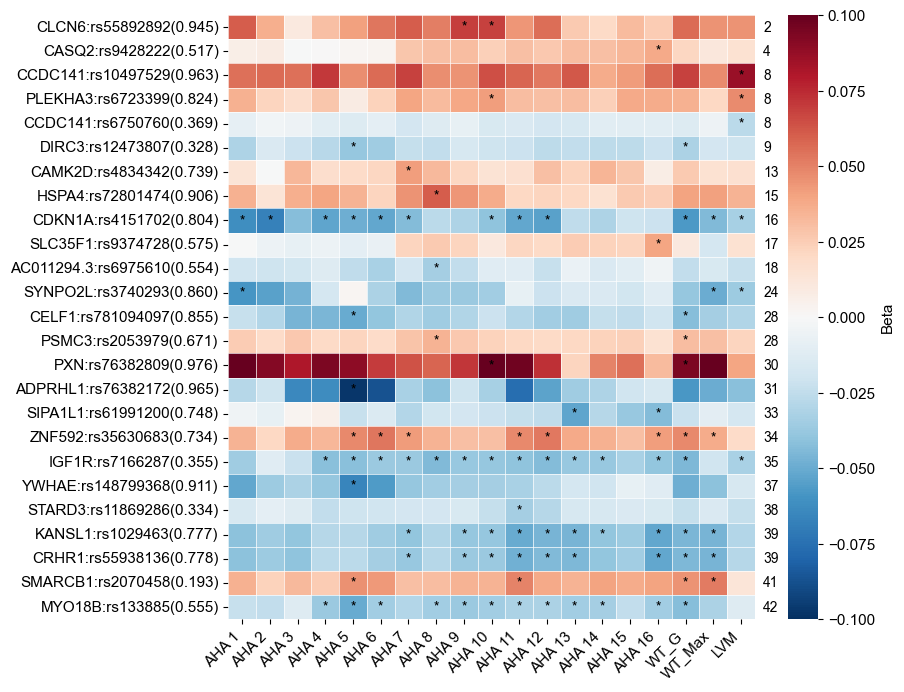

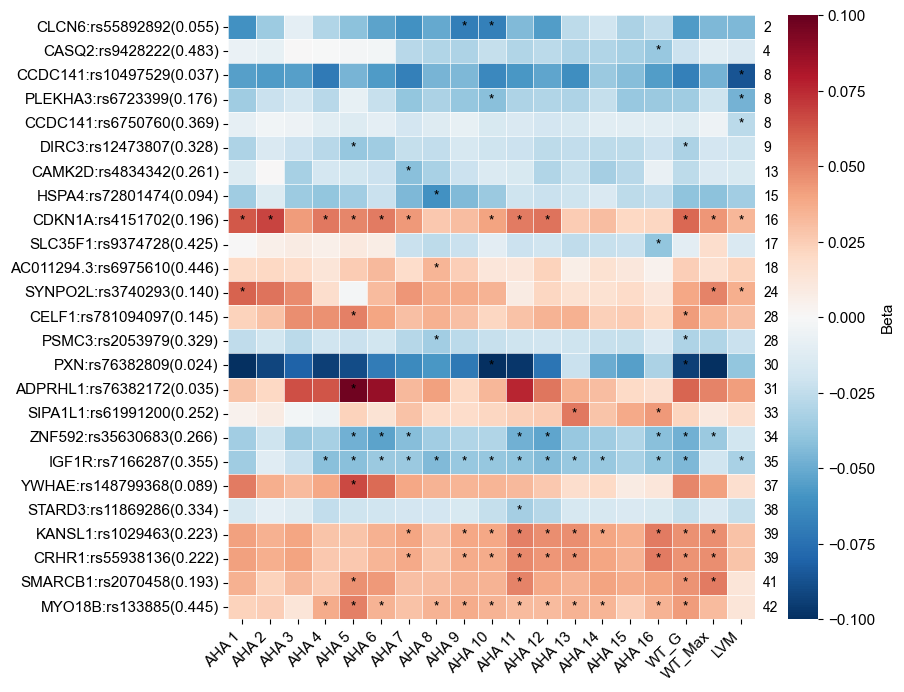

In [111]:
heatmap_locus_genes_WT = locus_all_leads[locus_all_leads.WT==1]
heatmap_locus_genes_WT = heatmap_locus_genes_WT.merge(exome_spatial, on='SNPID', how='left')
sel_traits = [f'WT_AHA_{i}' for i in range(1,17)] + ['WT_Global', 'WT_Max_Global', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['WT_G', 'WT_Max', 'LVM']

heatmap_locus_genes_WT = heatmap_locus_genes_WT.assign(label = [f'{x}:{y}({z:.3f})' for x, y, z in zip(heatmap_locus_genes_WT.GENE, heatmap_locus_genes_WT.SNPID, heatmap_locus_genes_WT.EAF)])
plot_heatmap_beta(heatmap_locus_genes_WT, sel_traits, sel_traits_names, savepath='arrayGWAS_WT_heatmap_EAF.pdf')

# swap beta if EAF > 0.5
for trait in sel_traits:
    heatmap_locus_genes_WT.loc[heatmap_locus_genes_WT.EAF>0.5, f'{trait}_BETA'] = -heatmap_locus_genes_WT.loc[heatmap_locus_genes_WT.EAF>0.5, f'{trait}_BETA']

heatmap_locus_genes_WT = heatmap_locus_genes_WT.assign(MAF = [min(x, 1-x) for x in heatmap_locus_genes_WT.EAF])
heatmap_locus_genes_WT = heatmap_locus_genes_WT.assign(label = [f'{x}:{y}({z:.3f})' for x, y, z in zip(heatmap_locus_genes_WT.GENE, heatmap_locus_genes_WT.SNPID, heatmap_locus_genes_WT.MAF)])
plot_heatmap_beta(heatmap_locus_genes_WT, sel_traits, sel_traits_names, savepath='arrayGWAS_WT_heatmap_MAF.pdf')

# Ecc lead SNPs heatmap plot to show individual spatial signals

In [ ]:
# read the beta and p values for the hits for WT AHA segments
def filter_summstats(gwaspath, filtersnps):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # just take the lead snps
    mysumstats.data = mysumstats.data[mysumstats.data['SNPID'].isin(filtersnps)]
    return mysumstats.data

sel_traits = [f'Ecc_AHA_{i}' for i in range(1,17)] + ['Ecc_Global', 'LVEF', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['-Ecc_G', 'LVEF', 'LVM']

exome_spatial_WT = pd.DataFrame()
for it, trait in enumerate(sel_traits):
    print(trait, exome_spatial_WT.shape)
    if 'AHA' in trait:
        eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/40kahat64_sexagebmibsa2bp_{trait}_chrmerged.regenie.gz', filter_snpids)
    else:
        eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/AHA_40k_t14_2bp_full_{trait}_chrmerged.regenie.gz', filter_snpids)
    # Ecc only
    eachone['BETA'] = -eachone['BETA']
    eachone = eachone[[
        'SNPID', 'BETA', 'MLOG10P', 'SE'
    ]].rename(columns={
        'BETA': f'{trait}_BETA',
        'MLOG10P': f'{trait}_MLOG10P',
        'SE': f'{trait}_SE'
    })
    if it == 0:
        exome_spatial_WT = eachone
    else:
        exome_spatial_WT = pd.merge(exome_spatial_WT, eachone, on='SNPID', how='left')

exome_spatial_WT.to_csv('arrayGWAS_beta_Ecc.csv.gz', index=False)

eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/AHA_40k_t14_2bp_full_{trait}_chrmerged.regenie.gz', filter_snpids)
snp_info = eachone[['SNPID', 'EA', 'NEA', 'EAF', 'N']]

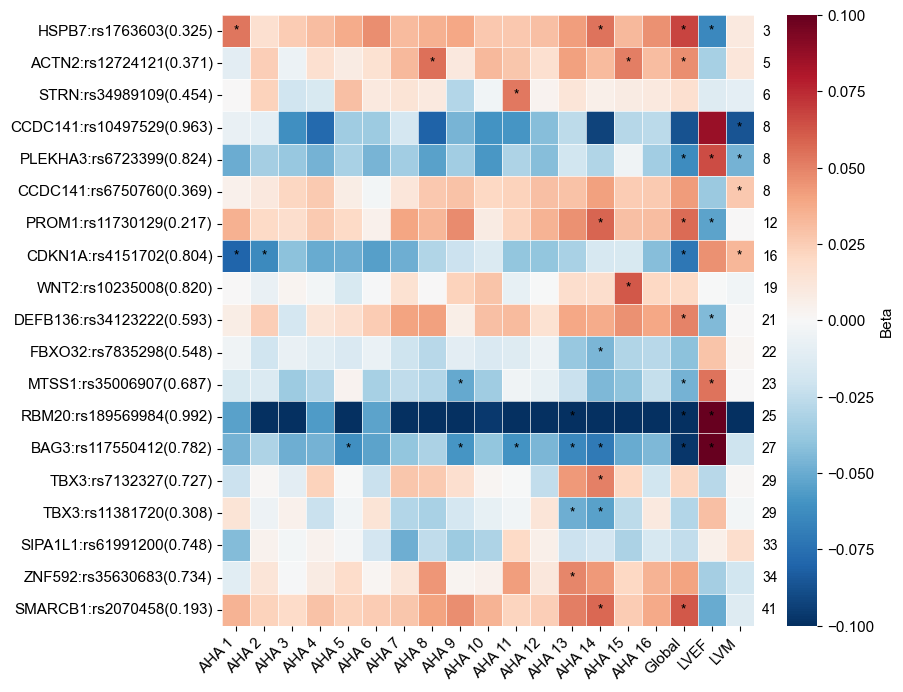

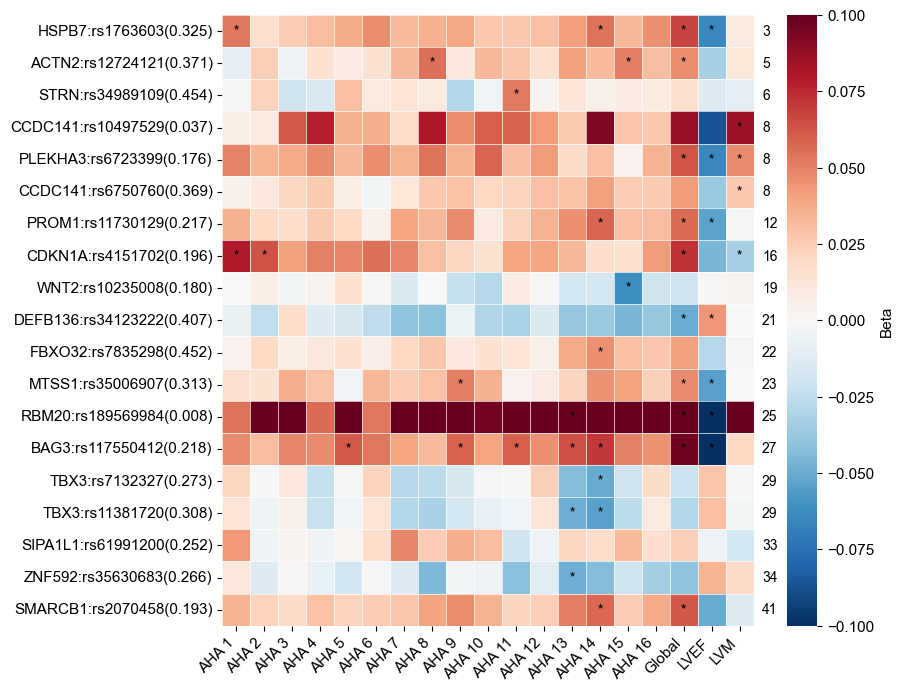

In [117]:
heatmap_locus_genes = locus_all_leads[locus_all_leads.Ecc==1]
heatmap_locus_genes = heatmap_locus_genes.merge(exome_spatial_WT, on='SNPID', how='left')
sel_traits = [f'Ecc_AHA_{i}' for i in range(1,17)] + ['Ecc_Global', 'LVEF', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Global', 'LVEF', 'LVM']

heatmap_locus_genes = heatmap_locus_genes.assign(label = [f'{x}:{y}({z:.3f})' for x, y, z in zip(heatmap_locus_genes.GENE, heatmap_locus_genes.SNPID, heatmap_locus_genes.EAF)])
plot_heatmap_beta(heatmap_locus_genes, sel_traits, sel_traits_names, savepath='arrayGWAS_Ecc_heatmap_EAF.pdf')

# swap beta if EAF > 0.5
for trait in sel_traits:
    heatmap_locus_genes.loc[heatmap_locus_genes.EAF>0.5, f'{trait}_BETA'] = -heatmap_locus_genes.loc[heatmap_locus_genes.EAF>0.5, f'{trait}_BETA']

heatmap_locus_genes = heatmap_locus_genes.assign(MAF = [min(x, 1-x) for x in heatmap_locus_genes.EAF])
heatmap_locus_genes = heatmap_locus_genes.assign(label = [f'{x}:{y}({z:.3f})' for x, y, z in zip(heatmap_locus_genes.GENE, heatmap_locus_genes.SNPID, heatmap_locus_genes.MAF)])
plot_heatmap_beta(heatmap_locus_genes, sel_traits, sel_traits_names, savepath='arrayGWAS_Ecc_heatmap_MAF.pdf')

heatmap_locus_genes.to_csv('arrayGWAS_beta_Ecc.csv.gz', index=False)

# Err lead SNPs heatmap plot to show individual spatial signals

In [ ]:
# read the beta and p values for the hits for WT AHA segments
def filter_summstats(gwaspath, filtersnps):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # just take the lead snps
    mysumstats.data = mysumstats.data[mysumstats.data['SNPID'].isin(filtersnps)]
    return mysumstats.data

sel_traits = [f'Err_AHA_{i}' for i in range(1,17)] + ['Err_Global', 'LVEF', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Err_G', 'LVEF', 'LVM']

exome_spatial = pd.DataFrame()
for it, trait in enumerate(sel_traits):
    print(trait, exome_spatial.shape)
    if 'AHA' in trait:
        eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/40kahat64_sexagebmibsa2bp_{trait}_chrmerged.regenie.gz', filter_snpids)
    else:
        eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/AHA_40k_t14_2bp_full_{trait}_chrmerged.regenie.gz', filter_snpids)
    eachone = eachone[[
        'SNPID', 'BETA', 'MLOG10P', 'SE'
    ]].rename(columns={
        'BETA': f'{trait}_BETA',
        'MLOG10P': f'{trait}_MLOG10P',
        'SE': f'{trait}_SE'
    })
    if it == 0:
        exome_spatial = eachone
    else:
        exome_spatial = pd.merge(exome_spatial, eachone, on='SNPID', how='left')

exome_spatial.to_csv('arrayGWAS_beta_Err.csv.gz', index=False)

eachone = filter_summstats(f'cardiac/48K/gwas_aha_t64/gwas_raw/AHA_40k_t14_2bp_full_{trait}_chrmerged.regenie.gz', filter_snpids)
snp_info = eachone[['SNPID', 'EA', 'NEA', 'EAF', 'N']]


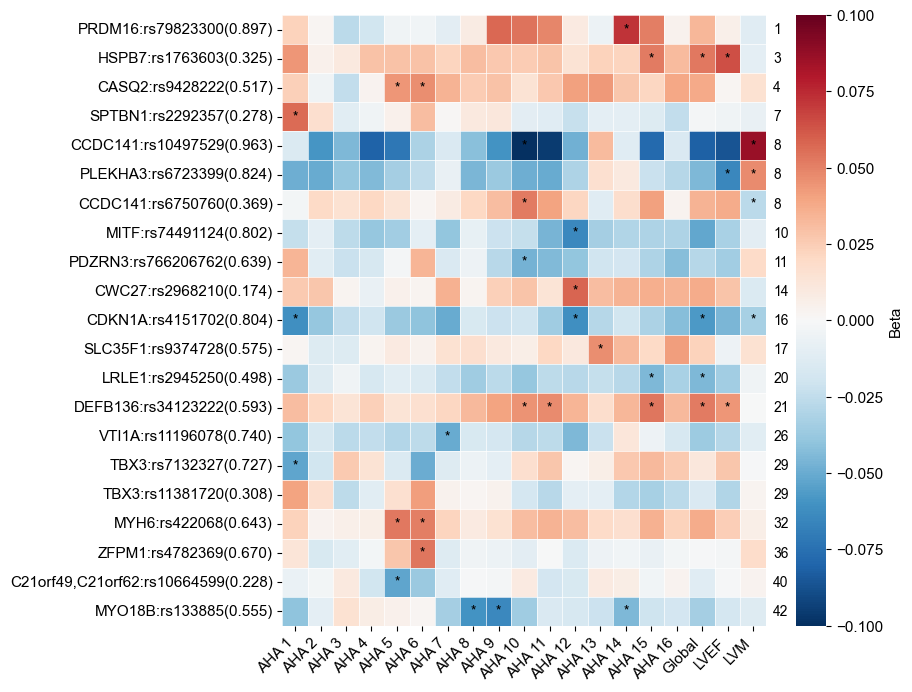

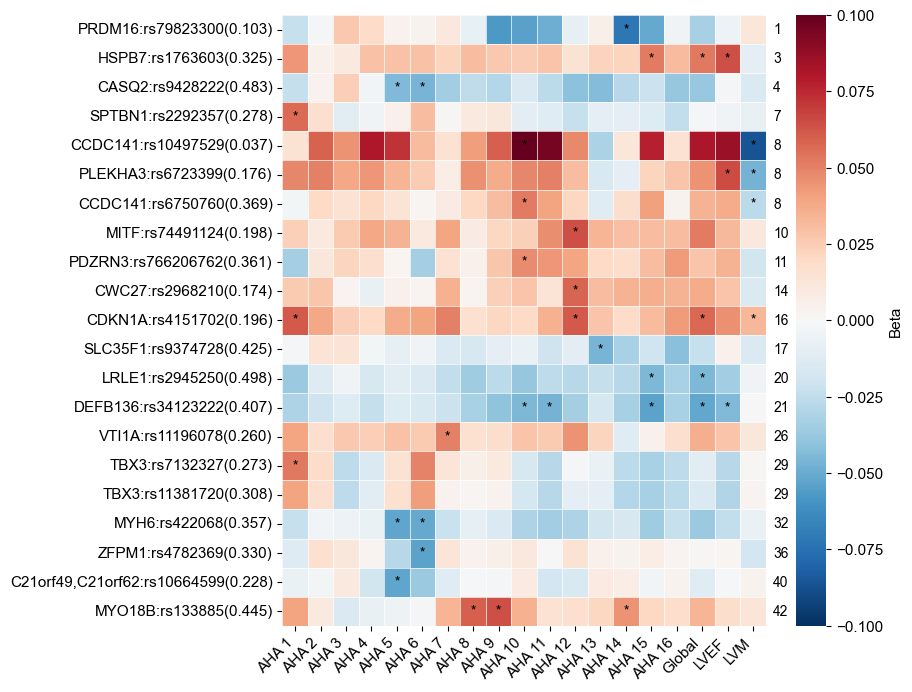

In [127]:
heatmap_locus_genes = locus_all_leads[locus_all_leads.Err==1]
heatmap_locus_genes = heatmap_locus_genes.merge(exome_spatial, on='SNPID', how='left')
sel_traits = [f'Err_AHA_{i}' for i in range(1,17)] + ['Err_Global', 'LVEF', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Global', 'LVEF', 'LVM']

heatmap_locus_genes = heatmap_locus_genes.assign(label = [f'{x}:{y}({z:.3f})' for x, y, z in zip(heatmap_locus_genes.GENE, heatmap_locus_genes.SNPID, heatmap_locus_genes.EAF)])
plot_heatmap_beta(heatmap_locus_genes, sel_traits, sel_traits_names, savepath='arrayGWAS_Err_heatmap_EAF.pdf')

# swap beta if EAF > 0.5
for trait in sel_traits:
    heatmap_locus_genes.loc[heatmap_locus_genes.EAF>0.5, f'{trait}_BETA'] = -heatmap_locus_genes.loc[heatmap_locus_genes.EAF>0.5, f'{trait}_BETA']

heatmap_locus_genes = heatmap_locus_genes.assign(MAF = [min(x, 1-x) for x in heatmap_locus_genes.EAF])
heatmap_locus_genes = heatmap_locus_genes.assign(label = [f'{x}:{y}({z:.3f})' for x, y, z in zip(heatmap_locus_genes.GENE, heatmap_locus_genes.SNPID, heatmap_locus_genes.MAF)])
plot_heatmap_beta(heatmap_locus_genes, sel_traits, sel_traits_names, savepath='arrayGWAS_Err_heatmap_MAF.pdf')

heatmap_locus_genes.to_csv('arrayGWAS_beta_Err.csv.gz', index=False)